# <div style="color:white;display:fill;border-radius:5px;background-color:#296ae3;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:110%"><b></b> Dynamic Ensemble Selection for Ants and Bees dataset </p></div>

In [1]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from medmnist import INFO
import numpy as np
import faiss
import copy

import warnings
warnings.filterwarnings("ignore")

In [2]:
torch.__version__

'2.6.0+cu118'

In [372]:
## GLOBAL 

CHANNELS = 3 
N_CLASSES = 2
N_EPOCHS = 50 

device = torch.device('cuda:0') 

### Step 1: Setup and Data Loading

In [206]:
import os
from torchvision import datasets, transforms
import torch

print(f"Step 1: Loading dataset with resize transform...")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]) 
])

data_dir = 'dataset/hymenoptera_data' 

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), transform=transform)
    for x in ['train', 'val']
}

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
    for x in ['train', 'val']
}

val_dataset = image_datasets['val']

val_loader = dataloaders['val'] 

print(f"Train samples: {len(image_datasets['train'])}, Validation samples: {len(image_datasets['val'])}")

Step 1: Loading dataset with resize transform...
Train samples: 244, Validation samples: 153


### Step 2: Define Embedding Model

### Step 3: Extract DSEL Embeddings

In [6]:
dino_model = timm.create_model('vit_base_patch16_224.dino', pretrained=True).to(device)
dino_model.eval()

def dino_embedder(images):
    if images.shape[1] == 1:
        images = images.repeat(1, 3, 1, 1)
    return dino_model.forward_features(images)

dsel_embeddings = []
dsel_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        embs = dino_embedder(imgs).cpu()
        dsel_embeddings.append(embs)
        dsel_labels.append(labels)

dsel_embeddings = torch.cat(dsel_embeddings).numpy().astype('float32')
dsel_labels = torch.cat(dsel_labels).numpy()

In [7]:
dsel_embeddings.shape

(153, 197, 768)

### Step 4: Build FAISS Index

In [8]:
# Build FAISS index
import faiss

cls_embeddings = dsel_embeddings[:, 0, :] 

embedding_dim = cls_embeddings.shape[1]  # 768 for DINO ViT
index = faiss.IndexFlatL2(embedding_dim)
index.add(cls_embeddings.astype('float32'))


### Step 5: Define Base Classifiers

In [268]:
print("\nStep 5: Defining base classifiers (ResNet, DenseNet, ViT)...")

import torch.nn as nn
from torchvision.models import (
    resnet50, resnet101, resnet152, vgg11, vgg19,
    densenet201, inception_v3, googlenet, efficientnet_b0,
    squeezenet1_1, shufflenet_v2_x1_0, mobilenet_v2, convnext_tiny
)
from torchvision.models.vision_transformer import vit_b_16
import timm

# -------------------------
# Utility base class
# -------------------------
class BaseClassifier(nn.Module):
    def __init__(self):
        super().__init__()

    def adapt_input(self, model, conv_attr='conv1', in_channels=1, out_channels=64, **kwargs):
        setattr(model, conv_attr, nn.Conv2d(in_channels, out_channels, kernel_size=7, stride=2, padding=3, bias=False))

# -------------------------
# ResNet Variants
# -------------------------
class ResNet50Classifier(BaseClassifier):
    def __init__(self):
        super().__init__()
        self.model = resnet50(pretrained=True)
        if CHANNELS == 1:
            self.adapt_input(self.model)
        self.model.fc = nn.Linear(2048, N_CLASSES)

    def forward(self, x):
        return self.model(x)

class ResNet101Classifier(BaseClassifier):
    def __init__(self):
        super().__init__()
        self.model = resnet101(pretrained=True)
        if CHANNELS == 1:
            self.adapt_input(self.model)
        self.model.fc = nn.Linear(2048, N_CLASSES)

    def forward(self, x):
        return self.model(x)

class ResNet152Classifier(BaseClassifier):
    def __init__(self):
        super().__init__()
        self.model = resnet152(pretrained=True)
        if CHANNELS == 1:
            self.adapt_input(self.model)
        self.model.fc = nn.Linear(2048, N_CLASSES)

    def forward(self, x):
        return self.model(x)

# -------------------------
# VGG
# -------------------------
class VGG11Classifier(BaseClassifier):
    def __init__(self):
        super().__init__()
        self.model = vgg11(pretrained=True)
        if CHANNELS == 1:
            self.model.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.model.classifier[6] = nn.Linear(4096, N_CLASSES)

    def forward(self, x):
        return self.model(x)

class VGG19Classifier(BaseClassifier):
    def __init__(self):
        super().__init__()
        self.model = vgg19(pretrained=True)
        if CHANNELS == 1:
            self.model.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.model.classifier[6] = nn.Linear(4096, N_CLASSES)

    def forward(self, x):
        return self.model(x)

# -------------------------
# DenseNet
# -------------------------
class DenseNet201Classifier(BaseClassifier):
    def __init__(self):
        super().__init__()
        self.model = densenet201(pretrained=True)
        if CHANNELS == 1:
            self.model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.classifier = nn.Linear(self.model.classifier.in_features, N_CLASSES)

    def forward(self, x):
        return self.model(x)

# -------------------------
# Inception & GoogLeNet
# -------------------------
class InceptionV3Classifier(BaseClassifier):
    def __init__(self):
        super().__init__()
        self.model = inception_v3(pretrained=True, aux_logits=True)
        if CHANNELS == 1:
            self.model.Conv2d_1a_3x3.conv = nn.Conv2d(1, 32, kernel_size=3, stride=2)
        self.model.fc = nn.Linear(2048, N_CLASSES)

    def forward(self, x):
        return self.model(x)

class GoogLeNetClassifier(BaseClassifier):
    def __init__(self):
        super().__init__()
        self.model = googlenet(pretrained=True, aux_logits=True)
        if CHANNELS == 1:
            self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(1024, N_CLASSES)

    def forward(self, x):
        return self.model(x)

# -------------------------
# EfficientNet
# -------------------------
class EfficientNetB0Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = efficientnet_b0(pretrained=True)
        if CHANNELS == 1:
            self.model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, N_CLASSES)

    def forward(self, x):
        return self.model(x)

# -------------------------
# MobileNet, ShuffleNet, SqueezeNet
# -------------------------
class MobileNetV2Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = mobilenet_v2(pretrained=True)
        if CHANNELS == 1:
            self.model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, N_CLASSES)

    def forward(self, x):
        return self.model(x)

class SqueezeNetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = squeezenet1_1(pretrained=True)
        if CHANNELS == 1:
            self.model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=2)
        self.model.classifier[1] = nn.Conv2d(512, N_CLASSES, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, x):
        return self.model(x)

class ShuffleNetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = shufflenet_v2_x1_0(pretrained=True)
        if CHANNELS == 1:
            self.model.conv1[0] = nn.Conv2d(1, 24, kernel_size=3, stride=2, padding=1, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, N_CLASSES)

    def forward(self, x):
        return self.model(x)

# -------------------------
# ConvNeXt & ViT
# -------------------------
class ConvNeXtTinyClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = convnext_tiny(pretrained=True)
        if CHANNELS == 1:
            self.model.features[0][0] = nn.Conv2d(1, 96, kernel_size=4, stride=4)
        self.model.classifier[2] = nn.Linear(self.model.classifier[2].in_features, N_CLASSES)

    def forward(self, x):
        return self.model(x)

class ViTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = vit_b_16(pretrained=True)
        if CHANNELS == 1:
            self.model.conv_proj = nn.Conv2d(1, 768, kernel_size=16, stride=16)
        self.model.heads.head = nn.Linear(768, N_CLASSES)

    def forward(self, x):
        return self.model(x)

# -------------------------
# ShallowNet (custom simple CNN)
# -------------------------
class ShallowNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(CHANNELS, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(64, N_CLASSES)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


# -------------------------
# EfficientNetV2 (from timm)
# -------------------------
class EfficientNetV2SClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model(
            'efficientnetv2_rw_s', pretrained=True,
            in_chans=CHANNELS, num_classes=N_CLASSES
        )

    def forward(self, x):
        return self.model(x)

# -------------------------
# RegNet (RegNetY-400MF)
# -------------------------
class RegNetY400MFClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model(
            'regnety_400mf', pretrained=True,
            in_chans=CHANNELS, num_classes=N_CLASSES
        )

    def forward(self, x):
        return self.model(x)

# -------------------------
# Swin Transformer (small)
# -------------------------
class SwinTransformerSmallClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model(
            'swin_small_patch4_window7_224', pretrained=True,
            in_chans=CHANNELS, num_classes=N_CLASSES
        )

    def forward(self, x):
        return self.model(x)



Step 5: Defining base classifiers (ResNet, DenseNet, ViT)...


### Step 6: Train Function with Printouts

In [373]:
def train_model(model_class, seed, epochs=10):
    print(f"\nTraining {model_class.__name__} with seed {seed} for {epochs} epochs...")
    torch.manual_seed(seed)
    model = model_class().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loader = dataloaders['train']

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for x, y in loader:
            x, y = x.to(device), y.squeeze().long().to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += x.size(0)

        avg_loss = total_loss / total
        accuracy = correct / total * 100
        print(f"Epoch {epoch}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return copy.deepcopy(model.to('cpu'))

### Step 7: Train the Pool of Classifiers

In [374]:
pool = [
    train_model(ResNet152Classifier, 45, N_EPOCHS), 
    train_model(DenseNet201Classifier, 45, N_EPOCHS),
    train_model(ResNet50Classifier, 99, N_EPOCHS),
    train_model(SqueezeNetClassifier, 99, N_EPOCHS),
    train_model(EfficientNetV2SClassifier, 0, N_EPOCHS),
    train_model(MobileNetV2Classifier, 42, N_EPOCHS),
]



Training ResNet152Classifier with seed 45 for 50 epochs...


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /home/infolab/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|█████████████████████████████████████████████████████████████| 230M/230M [00:02<00:00, 117MB/s]


Epoch 1/50 - Loss: 0.9859, Accuracy: 53.28%
Epoch 2/50 - Loss: 0.6907, Accuracy: 55.74%
Epoch 3/50 - Loss: 0.6881, Accuracy: 58.61%
Epoch 4/50 - Loss: 0.7314, Accuracy: 49.59%
Epoch 5/50 - Loss: 0.6905, Accuracy: 52.87%
Epoch 6/50 - Loss: 0.6736, Accuracy: 64.75%
Epoch 7/50 - Loss: 0.6761, Accuracy: 58.61%
Epoch 8/50 - Loss: 0.6852, Accuracy: 55.74%
Epoch 9/50 - Loss: 0.6558, Accuracy: 61.48%
Epoch 10/50 - Loss: 0.6616, Accuracy: 62.30%
Epoch 11/50 - Loss: 0.6513, Accuracy: 59.43%
Epoch 12/50 - Loss: 0.6172, Accuracy: 66.80%
Epoch 13/50 - Loss: 0.6890, Accuracy: 60.25%
Epoch 14/50 - Loss: 0.6550, Accuracy: 59.02%
Epoch 15/50 - Loss: 0.6591, Accuracy: 60.66%
Epoch 16/50 - Loss: 0.6722, Accuracy: 57.79%
Epoch 17/50 - Loss: 0.6704, Accuracy: 63.11%
Epoch 18/50 - Loss: 0.6770, Accuracy: 54.51%
Epoch 19/50 - Loss: 0.6200, Accuracy: 67.62%
Epoch 20/50 - Loss: 0.6357, Accuracy: 65.57%
Epoch 21/50 - Loss: 0.6122, Accuracy: 66.39%
Epoch 22/50 - Loss: 0.6618, Accuracy: 63.52%
Epoch 23/50 - Loss:

In [375]:
def evaluate_pool(pool):
    print("\nEvaluating individual classifiers on test set...")
    test_loader = dataloaders['val']

    for i, model in enumerate(pool):
        model = model.to(device)  # <- Ensure model is on the correct device
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.squeeze().long().to(device)
                outputs = model(imgs)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.numel()
        acc = correct / total * 100
        print(f"Classifier {i+1} ({model.__class__.__name__}): Accuracy = {acc:.2f}%")

evaluate_pool(pool)


Evaluating individual classifiers on test set...
Classifier 1 (ResNet152Classifier): Accuracy = 73.20%
Classifier 2 (DenseNet201Classifier): Accuracy = 73.86%
Classifier 3 (ResNet50Classifier): Accuracy = 58.82%
Classifier 4 (SqueezeNetClassifier): Accuracy = 45.75%
Classifier 5 (EfficientNetV2SClassifier): Accuracy = 85.62%
Classifier 6 (MobileNetV2Classifier): Accuracy = 53.59%


### Step 8: Define Competence and Dynamic Ensemble Prediction

In [376]:
def get_output_size(model):
    """
    Returns the output size (number of classes) from various model architectures.
    """
    if hasattr(model, 'fc'):
        return model.fc.out_features
    elif hasattr(model, 'classifier'):
        if isinstance(model.classifier, nn.Sequential):
            return model.classifier[-1].out_features
        else:
            return model.classifier.out_features
    elif hasattr(model, 'heads'):  # ViT / DINO from torchvision
        return model.heads.head.out_features
    elif hasattr(model, 'head'):  # ViT/Swin from timm
        return model.head.out_features
    else:
        raise AttributeError("Cannot determine output size of the model.")


def des_predict_weighted(test_img, pool, index, dsel_embeddings, dsel_labels, k=7):
    """
    Dynamic ensemble prediction using weighted voting based on local competence.
    """
    # Step 1: Extract test embedding from DINO
    test_img = test_img.unsqueeze(0).to(device)
    with torch.no_grad():
        if test_img.shape[1] == 1:
            test_img = test_img.repeat(1, 3, 1, 1)
        test_emb = dino_model.forward_features(test_img).cpu().numpy().astype('float32')
        test_emb = test_emb[:, 0, :]  # CLS token only

    # Step 2: Find k nearest neighbors using FAISS
    _, neighbors = index.search(test_emb, k)
    neighbor_idxs = neighbors[0]
    local_labels = dsel_labels[neighbor_idxs]

    # Step 3: Compute competence of each classifier on Region of Competence
    competences = []
    for clf in pool:
        clf.eval()
        with torch.no_grad():
            roc_imgs = torch.stack([val_dataset[idx][0] for idx in neighbor_idxs]).to(device)
            outputs = clf(roc_imgs)
            preds = outputs.argmax(dim=1).cpu().numpy()
        correct = (preds == local_labels).sum()
        competence = correct / k
        competences.append(competence)

    print(competences) 
    
    # Step 4: Normalize competences
    total_comp = sum(competences)
    if total_comp == 0:
        competences = [1.0 / len(pool)] * len(pool)  # fallback: equal weights
    else:
        competences = [c / total_comp for c in competences]

    # Step 5: Weighted sum of classifier outputs
    test_img = test_img.to(device)
    num_classes = get_output_size(pool[0].model)  # works for ResNet, VGG, ViT, etc.
    weighted_logits = torch.zeros(num_classes).to(device)

    for clf, weight in zip(pool, competences):
        clf.eval()
        with torch.no_grad():
            logits = clf(test_img).squeeze(0)  # shape (num_classes,)
            print(logits)
            weighted_logits += weight * logits

    # Step 6: Final prediction
    final_pred = weighted_logits.argmax().item()
    return final_pred

### Step 9: Evaluate Dynamic Ensemble on Test Set

In [377]:
def denormalize(tensor, mean, std):
    """
    Denormalizes a tensor image using the given mean and std.
    """
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor 

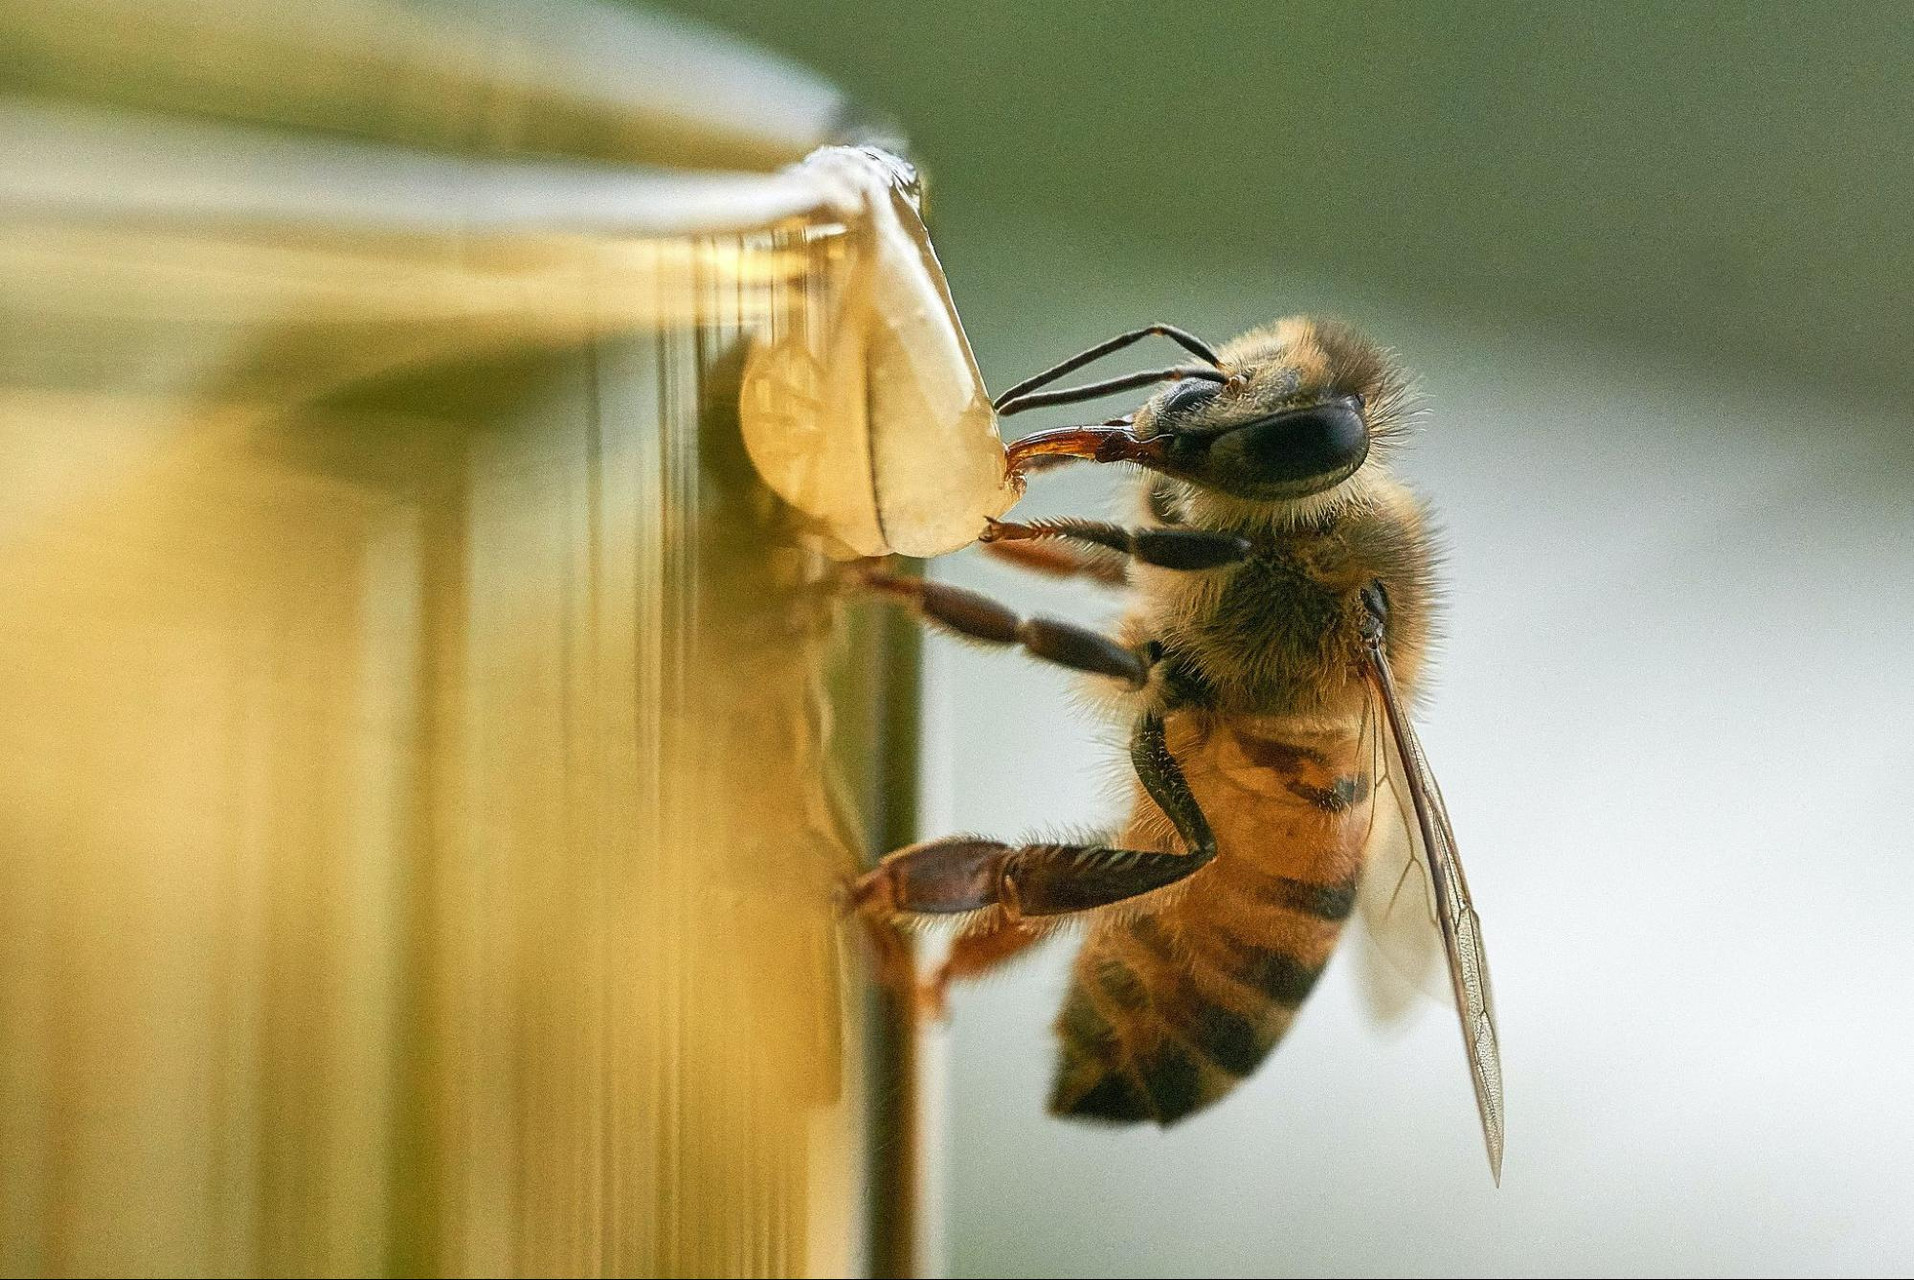

In [396]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np


test_path = 'dataset/test_data/bee_test_2.jpg' 

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]) 
])


test_img_pil = Image.open(test_path)
test_img_tensor = transform(test_img_pil).unsqueeze(0).to(device) 

test_img_pil

In [397]:
# Step 1: Extract embedding using DINO
with torch.no_grad():
    img_for_dino = test_img_tensor
    if img_tensor.shape[1] == 1:
        img_for_dino = img_tensor.repeat(1, 3, 1, 1)  # DINO requires 3 channels
    test_emb = dino_model.forward_features(img_for_dino).cpu().numpy().astype('float32')
    test_emb = test_emb[:, 0, :]  # CLS token 

In [398]:
test_emb.shape

(1, 768)

In [399]:
k = 7
_, neighbor_idxs = index.search(test_emb, k)
neighbor_idxs = neighbor_idxs[0]  # shape (k,)

neighbor_imgs = [image_datasets['val'][idx][0] for idx in neighbor_idxs]      # PIL images transformed to tensors
neighbor_labels = [image_datasets['val'][idx][1] for idx in neighbor_idxs]    # numeric labels

In [400]:
neighbor_idxs

array([119,  99,  86,  47, 132,   0,   6])

In [401]:
neighbor_labels 

[1, 1, 1, 0, 1, 0, 0]

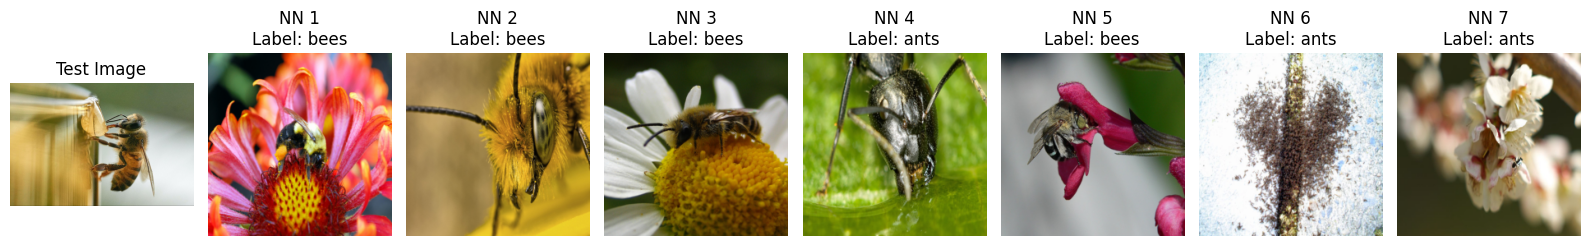

In [402]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

fig, axes = plt.subplots(1, len(neighbor_imgs) + 1, figsize=(16, 4))

# Show test image
axes[0].imshow(test_img_pil)
axes[0].set_title("Test Image")
axes[0].axis('off')

# Show neighbors
for i, (img_tensor, label) in enumerate(zip(neighbor_imgs, neighbor_labels)):
    img_denorm = denormalize(img_tensor, mean, std)
    img_pil = to_pil_image(img_denorm.clamp(0, 1))  # make sure values are in [0,1]
    
    axes[i+1].imshow(img_pil)
    axes[i+1].set_title(f"NN {i+1}\nLabel: {image_datasets['val'].classes[label]}")
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

### Attack 

In [403]:
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier

resnet_model = pool[3]  
resnet_model = resnet_model.to(device).eval()

# Dummy optimizer and loss (not used in eval)
dummy_optimizer = torch.optim.Adam(resnet_model.parameters())
loss_fn = nn.CrossEntropyLoss()

# Wrap it for ART
art_classifier = PyTorchClassifier(
    model=resnet_model,
    loss=loss_fn,
    optimizer=dummy_optimizer,
    input_shape=(1, 28, 28),  # BreastMNIST shape
    nb_classes=2,
    clip_values=(0.0, 1.0),
) 

In [404]:
test_img_tensor.shape

torch.Size([1, 3, 224, 224])

In [405]:
pgd_attack = ProjectedGradientDescent(estimator=art_classifier, eps=0.05, eps_step=0.01, max_iter=100)

x_test_adv = pgd_attack.generate(x=test_img_tensor.cpu().numpy()) 

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [406]:
torch.from_numpy(x_test_adv).shape

torch.Size([1, 3, 224, 224])

In [407]:
# Step 1: Extract embedding using DINO
with torch.no_grad():
    img_for_dino = torch.from_numpy(x_test_adv).to(device)
    if img_tensor.shape[1] == 1:
        img_for_dino = img_tensor.repeat(1, 3, 1, 1)  # DINO requires 3 channels
    test_emb = dino_model.forward_features(img_for_dino).cpu().numpy().astype('float32')
    test_emb = test_emb[:, 0, :]  # CLS token  

In [408]:
k = 7
_, neighbor_idxs = index.search(test_emb, k)
neighbor_idxs = neighbor_idxs[0]  # shape (k,)

neighbor_imgs = [image_datasets['val'][idx][0] for idx in neighbor_idxs]      # PIL images transformed to tensors
neighbor_labels = [image_datasets['val'][idx][1] for idx in neighbor_idxs]    # numeric labels 

In [409]:
neighbor_idxs

array([119,  99,  86,  47, 132,   0,   6])

In [410]:
neighbor_labels

[1, 1, 1, 0, 1, 0, 0]

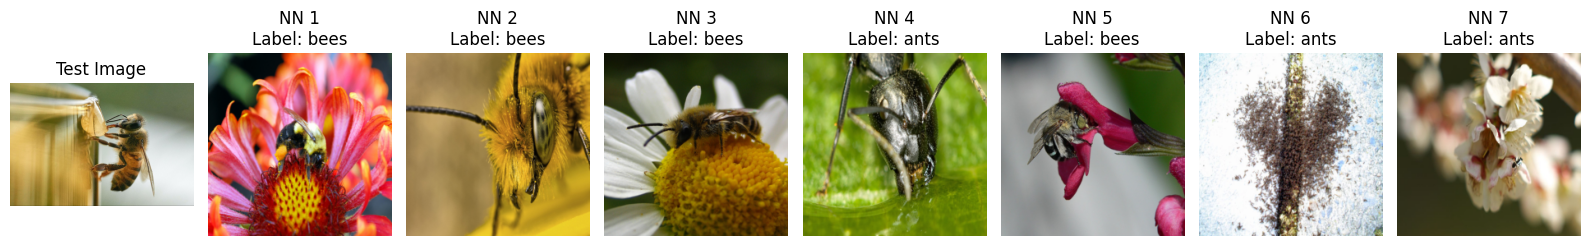

In [411]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

fig, axes = plt.subplots(1, len(neighbor_imgs) + 1, figsize=(16, 4))

# Show test image
axes[0].imshow(test_img_pil)  # assuming test_img_pil is already loaded
axes[0].set_title("Test Image")
axes[0].axis('off')

# Show neighbors
for i, (img_tensor, label) in enumerate(zip(neighbor_imgs, neighbor_labels)):
    img_denorm = denormalize(img_tensor, mean, std)
    img_pil = to_pil_image(img_denorm.clamp(0, 1))  # make sure values are in [0,1]
    
    axes[i+1].imshow(img_pil)
    axes[i+1].set_title(f"NN {i+1}\nLabel: {image_datasets['val'].classes[label]}")
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

In [412]:
for i in range(len(pool)): 
    print(f"{pool[i].__class__.__name__} ------- pred: {pool[i](torch.from_numpy(x_test_adv).to(device))}")


ResNet152Classifier ------- pred: tensor([[ 0.4219, -0.3194]], device='cuda:0', grad_fn=<AddmmBackward0>)
DenseNet201Classifier ------- pred: tensor([[-0.0061, -0.0287]], device='cuda:0', grad_fn=<AddmmBackward0>)
ResNet50Classifier ------- pred: tensor([[ 0.9911, -1.0146]], device='cuda:0', grad_fn=<AddmmBackward0>)
SqueezeNetClassifier ------- pred: tensor([[0., 0.]], device='cuda:0', grad_fn=<ViewBackward0>)
EfficientNetV2SClassifier ------- pred: tensor([[-4.7204,  4.5309]], device='cuda:0', grad_fn=<AddmmBackward0>)
MobileNetV2Classifier ------- pred: tensor([[-0.2719,  0.2672]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [413]:
pool[1](torch.from_numpy(x_test_adv).to(device)) 

tensor([[-0.0061, -0.0287]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [414]:
pool[3](torch.from_numpy(x_test_adv).to(device))

tensor([[0., 0.]], device='cuda:0', grad_fn=<ViewBackward0>)

In [415]:
pool[2](torch.from_numpy(x_test_adv).to(device))

tensor([[ 0.9911, -1.0146]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [416]:
pool[4](torch.from_numpy(x_test_adv).to(device)) 

tensor([[-4.7204,  4.5309]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [417]:
x_test = torch.from_numpy(x_test_adv) #.to(device) 

pred = des_predict_weighted(x_test[0], pool, index, dsel_embeddings, dsel_labels, k=7)
pred

[0.7142857142857143, 0.42857142857142855, 0.2857142857142857, 0.0, 0.7142857142857143, 0.14285714285714285]
tensor([ 0.4219, -0.3194], device='cuda:0')
tensor([-0.0061, -0.0287], device='cuda:0')
tensor([ 0.9911, -1.0146], device='cuda:0')
tensor([0., 0.], device='cuda:0')
tensor([-4.7204,  4.5309], device='cuda:0')
tensor([-0.2719,  0.2672], device='cuda:0')


1

In [418]:
x_test = torch.from_numpy(x_test_adv) #.to(device) 

pred = des_predict_weighted(test_img_tensor[0], pool, index, dsel_embeddings, dsel_labels, k=7)
pred 

[0.7142857142857143, 0.42857142857142855, 0.2857142857142857, 0.0, 0.7142857142857143, 0.14285714285714285]
tensor([ 0.3843, -0.2802], device='cuda:0')
tensor([ 0.0294, -0.0599], device='cuda:0')
tensor([ 0.9050, -0.9301], device='cuda:0')
tensor([0., 0.], device='cuda:0')
tensor([-4.6292,  4.4898], device='cuda:0')
tensor([-0.2672,  0.2557], device='cuda:0')


1

In [419]:
# Convert ART's adversarial numpy output to tensor
adv_tensor = torch.tensor(x_test_adv).squeeze(0)  # shape: [C, H, W]

# Original image
original_tensor = test_img_tensor.squeeze(0).cpu()

# Denormalize both
original_denorm = denormalize(original_tensor, mean, std).clamp(0, 1)
adv_denorm = denormalize(adv_tensor, mean, std).clamp(0, 1)

# Convert to PIL
original_pil = to_pil_image(original_denorm)
adv_pil = to_pil_image(adv_denorm)

# Show both
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(original_pil)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(adv_pil)
axes[1].set_title("Adversarial Image (PGD)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [370]:
import torch.nn.functional as F

# Get embeddings from DINO (CLS token)
with torch.no_grad():
    orig_input = test_img_tensor.to(device)
    adv_input = torch.tensor(x_test_adv).to(device)

    # DINO expects 3 channels — duplicate grayscale if needed
    if orig_input.shape[1] == 1:
        orig_input = orig_input.repeat(1, 3, 1, 1)
        adv_input = adv_input.repeat(1, 3, 1, 1)

    orig_emb = dino_model.forward_features(orig_input)[:, 0, :]  # CLS token
    adv_emb = dino_model.forward_features(adv_input)[:, 0, :]

    # Cosine similarity (higher is more similar)
    cosine_sim = F.cosine_similarity(orig_emb, adv_emb).item()
    print(f"🔍 Cosine Similarity (DINO embeddings): {cosine_sim:.4f}")

🔍 Cosine Similarity (DINO embeddings): 0.9988


# <div style="color:white;display:fill;border-radius:5px;background-color:#f02263;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:110%"><b></b> Adversarial Attack </p></div>

In [65]:
import matplotlib.pyplot as plt

def show_adversarial_examples(x_test, x_test_adv, y_test, n=5):
    plt.figure(figsize=(n * 3, 4))
    for i in range(n):
        # Original image
        plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i][0], cmap='CMRmap')
        plt.title(f"Clean (Label={y_test[i]})")
        plt.axis('off')

        # Adversarial image
        plt.subplot(2, n, n + i + 1)
        plt.imshow(x_test_adv[i][0], cmap='CMRmap')
        plt.title(f"Adversarial")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


def evaluate_models_on_adversarial(pool, x_adv, y_true):
    print("\nEvaluating individual models on PGD adversarial test set...")
    for i, model in enumerate(pool):
        model = model.to(device).eval()
        correct = 0
        total = len(x_adv)

        with torch.no_grad():
            for j in range(total):
                img_tensor = torch.tensor(x_adv[j]).unsqueeze(0).float().to(device)
                label = torch.tensor(y_true[j]).long().to(device)

                output = model(img_tensor)
                pred = output.argmax(dim=1).item()

                if pred == label.item():
                    correct += 1

        acc = correct / total * 100
        print(f"Model {i+1} ({model.__class__.__name__}): Accuracy = {acc:.2f}%")

In [69]:
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier

resnet_model = pool[0]  
resnet_model = resnet_model.to(device).eval()

# Dummy optimizer and loss (not used in eval)
dummy_optimizer = torch.optim.Adam(resnet_model.parameters())
loss_fn = nn.CrossEntropyLoss()

# Wrap it for ART
art_classifier = PyTorchClassifier(
    model=resnet_model,
    loss=loss_fn,
    optimizer=dummy_optimizer,
    input_shape=(1, 28, 28),  # BreastMNIST shape
    nb_classes=2,
    clip_values=(0.0, 1.0),
)

In [68]:
x_test = []
y_test = []

for img, label in test_dataset:
    x_test.append(img.numpy())
    y_test.append(label.item())
    if len(x_test) >= 200:
        break  

x_test = np.array(x_test)
y_test = np.array(y_test)

NameError: name 'test_dataset' is not defined

In [33]:
pgd_attack = ProjectedGradientDescent(estimator=art_classifier, eps=0.01, eps_step=0.01, max_iter=100)

x_test_adv = pgd_attack.generate(x=x_test)

PGD - Batches:   0%|          | 0/7 [00:00<?, ?it/s]

### Test 

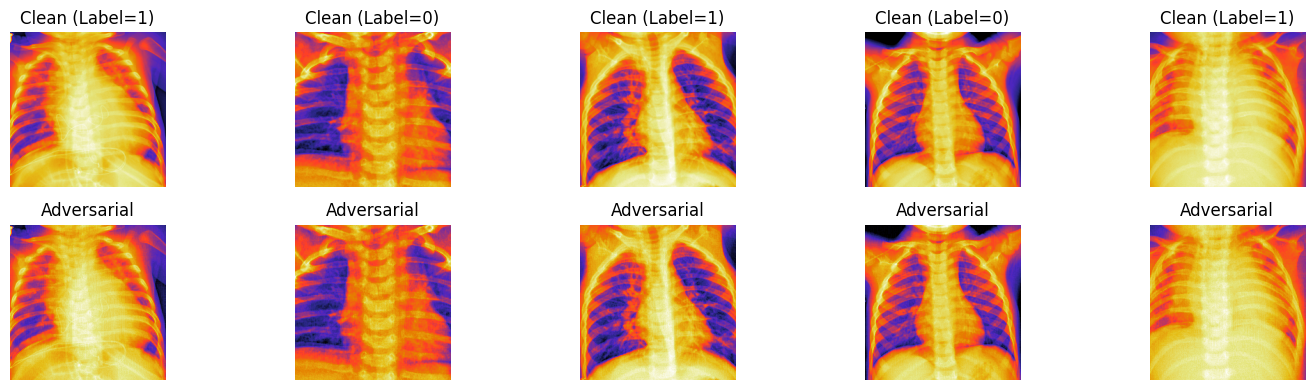

In [34]:
show_adversarial_examples(x_test, x_test_adv, y_test, n=5)

### Majority Voting based DES  

In [35]:
correct = 0
total = len(x_test_adv)

for i in range(total):
    img_tensor = torch.tensor(x_test_adv[i]).unsqueeze(0).float() 
    pred = predict_dynamic(img_tensor, index, pool, dsel_images, dsel_labels)
    if pred == y_test[i]:
        correct += 1

print(f"DES Accuracy on PGD adversarial test set: {correct / total:.4f}")

DES Accuracy on PGD adversarial test set: 0.2850


In [36]:
correct = 0
total = len(x_test)

for i in range(total):
    img_tensor = torch.tensor(x_test[i]).unsqueeze(0).float() 
    pred = predict_dynamic(img_tensor, index, pool, dsel_images, dsel_labels)
    if pred == y_test[i]:
        correct += 1

print(f"DES Accuracy on benign test set: {correct / total:.4f}") 

DES Accuracy on benign test set: 0.9050


### Dynamic Weighting based DES  

In [37]:
correct = 0
total = len(x_test_adv)

for i in range(total):
    img_tensor = torch.tensor(x_test_adv[i]).unsqueeze(0).float() 
    pred = predict_dynamic_weight(img_tensor, index, pool, dsel_images, dsel_labels)
    if pred == y_test[i]:
        correct += 1

print(f"DES Accuracy on PGD adversarial test set: {correct / total:.4f}")

DES Accuracy on PGD adversarial test set: 0.8550


In [38]:
correct = 0
total = len(x_test)

for i in range(total):
    img_tensor = torch.tensor(x_test[i]).unsqueeze(0).float() 
    pred = predict_dynamic_weight(img_tensor, index, pool, dsel_images, dsel_labels)
    if pred == y_test[i]:
        correct += 1

print(f"DES Accuracy on benign test set: {correct / total:.4f}") 

DES Accuracy on benign test set: 0.9050


In [39]:
evaluate_models_on_adversarial(pool, x_test_adv, y_test)


Evaluating individual models on PGD adversarial test set...
Model 1 (MobileNetClassifier): Accuracy = 11.50%
Model 2 (XceptionClassifier): Accuracy = 87.00%
Model 3 (ResNetClassifier): Accuracy = 90.50%
Model 4 (DenseNetClassifier): Accuracy = 88.00%
Model 5 (ViTClassifier): Accuracy = 77.50%


In [40]:
print("Benign image on pool")
evaluate_models_on_adversarial(pool, x_test, y_test)

Benign image on pool

Evaluating individual models on PGD adversarial test set...
Model 1 (MobileNetClassifier): Accuracy = 91.50%
Model 2 (XceptionClassifier): Accuracy = 89.50%
Model 3 (ResNetClassifier): Accuracy = 90.50%
Model 4 (DenseNetClassifier): Accuracy = 88.50%
Model 5 (ViTClassifier): Accuracy = 77.50%
